In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/preprocesseddata/Training/fourier1_x.csv
/kaggle/input/preprocesseddata/Training/fourdays_1.csv
/kaggle/input/preprocesseddata/Training/yearly_trend.csv
/kaggle/input/preprocesseddata/Training/access_ohe.csv
/kaggle/input/preprocesseddata/Training/weekly_trend.csv
/kaggle/input/preprocesseddata/Training/fourier2_y.csv
/kaggle/input/preprocesseddata/Training/spider_ohe.csv
/kaggle/input/preprocesseddata/Training/fourier3_y.csv
/kaggle/input/preprocesseddata/Training/fourdays_3.csv
/kaggle/input/preprocesseddata/Training/monthly_trend.csv
/kaggle/input/preprocesseddata/Training/fourier2_x.csv
/kaggle/input/preprocesseddata/Training/fourdays_2.csv
/kaggle/input/preprocesseddata/Training/prj_ohe.csv
/kaggle/input/preprocesseddata/Training/fourier1_y.csv
/kaggle/input/preprocesseddata/Training/week_day_ohe.csv
/kaggle/input/preprocesseddata/Training/rand_trend.csv
/kaggle/input/preprocesseddata/Training/target.csv
/kaggle/input/preprocesseddata/Training/fourier3_x.csv


In [2]:
import numpy as np 
import pandas as pd
from sklearn.metrics import make_scorer
!pip install xgboost
from xgboost import XGBRegressor
from math import sqrt
from sklearn.model_selection import GridSearchCV

In [3]:
file_paths = [
    '/kaggle/input/preprocesseddata/Training/access_ohe.csv',
    '/kaggle/input/preprocesseddata/Training/fourdays_1.csv',
    '/kaggle/input/preprocesseddata/Training/fourdays_2.csv',
    '/kaggle/input/preprocesseddata/Training/fourdays_3.csv',
    '/kaggle/input/preprocesseddata/Training/fourier1_x.csv',
    '/kaggle/input/preprocesseddata/Training/fourier2_x.csv',
    '/kaggle/input/preprocesseddata/Training/fourier3_x.csv',
    '/kaggle/input/preprocesseddata/Training/fourier1_y.csv',
    '/kaggle/input/preprocesseddata/Training/fourier2_y.csv',
    '/kaggle/input/preprocesseddata/Training/fourier3_y.csv',
    '/kaggle/input/preprocesseddata/Training/monthly_trend.csv',
    '/kaggle/input/preprocesseddata/Training/prj_ohe.csv',
    '/kaggle/input/preprocesseddata/Training/rand_trend.csv',
    '/kaggle/input/preprocesseddata/Training/spider_ohe.csv',
    '/kaggle/input/preprocesseddata/Training/week_day_ohe.csv',
    '/kaggle/input/preprocesseddata/Training/weekly_trend.csv',
    '/kaggle/input/preprocesseddata/Training/yearly_trend.csv',
    '/kaggle/input/preprocesseddata/Training/target.csv'
]

access_ohe = pd.read_csv(file_paths[0]).values
fourdays_1 = pd.read_csv(file_paths[1]).values
fourdays_2 = pd.read_csv(file_paths[2]).values
fourdays_3 = pd.read_csv(file_paths[3]).values
fourier1_x = pd.read_csv(file_paths[4]).values
fourier2_x = pd.read_csv(file_paths[5]).values
fourier3_x = pd.read_csv(file_paths[6]).values
fourier1_y = pd.read_csv(file_paths[7]).values
fourier2_y = pd.read_csv(file_paths[8]).values
fourier3_y = pd.read_csv(file_paths[9]).values
monthly_trend = pd.read_csv(file_paths[10]).values
prj_ohe = pd.read_csv(file_paths[11]).values
rand_trend = pd.read_csv(file_paths[12]).values
spider_ohe = pd.read_csv(file_paths[13]).values
week_day_ohe = pd.read_csv(file_paths[14]).values
weekly_trend = pd.read_csv(file_paths[15]).values
yearly_trend = pd.read_csv(file_paths[16]).values
target = pd.read_csv(file_paths[17]).values


In [4]:
data=np.column_stack((week_day_ohe,weekly_trend,fourdays_1,fourdays_2,
                      fourdays_3,prj_ohe,spider_ohe,access_ohe,fourier1_x,
                      fourier2_x,fourier3_x,fourier1_y,fourier2_y,fourier3_y,
                      monthly_trend,rand_trend,yearly_trend))

In [5]:
indices = np.random.permutation(data.shape[0]) # Shuffling the indexes of our data

training_idx, test_idx = indices[:int(0.75*data.shape[0])], indices[int(0.75*data.shape[0]):]

x_train,x_test = data[training_idx,:], data[test_idx,:]

y_train,y_test=target[training_idx,:],target[test_idx,:]

In [6]:
y_train=y_train.reshape(y_train.shape[0])
y_test=y_test.reshape(y_test.shape[0])

# Training

In [7]:
def smape(true_values, forecast_values):
    """
    Compute SMAPE (Symmetric Mean Absolute Percentage Error) given the true and forecast values.
    
    Args:
        true_values (numpy.ndarray): Array of true values.
        forecast_values (numpy.ndarray): Array of forecast values.
        
    Returns:
        float: SMAPE value between 0 and 100.
    """
    # Compute absolute difference and sum of absolute values
    abs_difference = np.abs(true_values - forecast_values)
    abs_sum = np.abs(true_values) + np.abs(forecast_values)
    
    # Avoid division by zero
    non_zero_mask = abs_sum != 0
    
    # Compute SMAPE
    smape_value = np.mean(100 * (abs_difference[non_zero_mask] / abs_sum[non_zero_mask]))
    
    return smape_value

In [8]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 10, 20],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# Create an instance of XGBRegressor
XGBR = XGBRegressor(verbosity=3, n_jobs=-1)

smape_scorer = make_scorer(smape, greater_is_better=False)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=XGBR, param_grid=param_grid, scoring=smape_scorer, cv=5, n_jobs=-1, verbose=3)
# Fit the grid search to the data
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[13:00:45] ======== Monitor (0): HostSketchContainer ========
[13:00:45] AllReduce: 0.035786s, 1 calls @ 35786us

[13:00:45] MakeCuts: 0.035972s, 1 calls @ 35972us

[13:00:45] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[13:01:02] ======== Monitor (0): Learner ========
[13:01:02] Configure: 0.001234s, 1 calls @ 1234us

[13:01:02] EvalOneIter: 0.000854s, 50 calls @ 854us

[13:01:02] GetGradient: 0.153141s, 50 calls @ 153141us

[13:01:02] PredictRaw: 0.001591s, 50 calls @ 1591us

[13:01:02] UpdateOneIter: 16.9022s, 50 calls @ 16902190us

[13:01:02] ======== Monitor (0): GBTree ========
[13:01:02] BoostNewTrees: 16.6964s, 50 calls @ 16696412us

[13:01:02] CommitModel: 0.000114s, 50 calls @ 114us

[13:01:02] ======== Monitor (0): HistUpdater ========
[13:01:02] BuildHistogram: 0.155615s, 200 calls @ 155615us

[13:01:02] EvaluateSplits: 0.032685s, 250 calls @ 32685us

[13:01:02] InitData: 0.219666s, 50 calls @ 

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[13:21:41] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=20, n_estimators=50, subsample=1.0;, score=-62.298 total time= 1.9min
[13:22:02] ======== Monitor (0): HostSketchContainer ========
[13:22:02] AllReduce: 0.025959s, 1 calls @ 25959us

[13:22:02] MakeCuts: 0.026175s, 1 calls @ 26175us

[13:22:02] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[13:25:31] ======== Monitor (0): Learner ========
[13:25:31] Configure: 0.001004s, 1 calls @ 1004us

[13:25:31] EvalOneIter: 0.001729s, 100 calls @ 1729us

[13:25:31] GetGradient: 0.293909s, 100 calls @ 293909us

[13:25:31] PredictRaw: 0.001808s, 100 calls @ 1808us

[13:25:31] UpdateOneIter: 208.923s, 100 calls @ 208922888us

[13:25:31] ======== Monitor (0): GBTree ========
[13:25:31] BoostNewTrees: 208.592s, 100 calls @ 208591687us

[13:25:31] CommitModel: 0.000192s, 100 calls @ 192us

[13:25:31] ======== Monitor (0): HistUpdater ========
[13:25:3

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=-1, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [5, 10, 20],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 1.0]},
             scoring=make_scorer(smape, greater_is_better=False), verbose=3)

In [9]:
# Print the best parameters and the corresponding score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 100, 'subsample': 1.0}
Best Score: 16.861648747757943


In [10]:
# Use the best model to make predictions on the test set
best_xgboost_model = grid_search.best_estimator_
pred_xgboost = best_xgboost_model.predict(x_test)

[17:40:27] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0


In [11]:
smape_score = smape(y_test, pred_xgboost)

print(f'SMAPE Score: {smape_score}')

SMAPE Score: 16.846655538944216


In [12]:
from joblib import dump

dump(best_xgboost_model, '/kaggle/working/best_xgboost_model2.joblib')

['/kaggle/working/best_xgboost_model2.joblib']

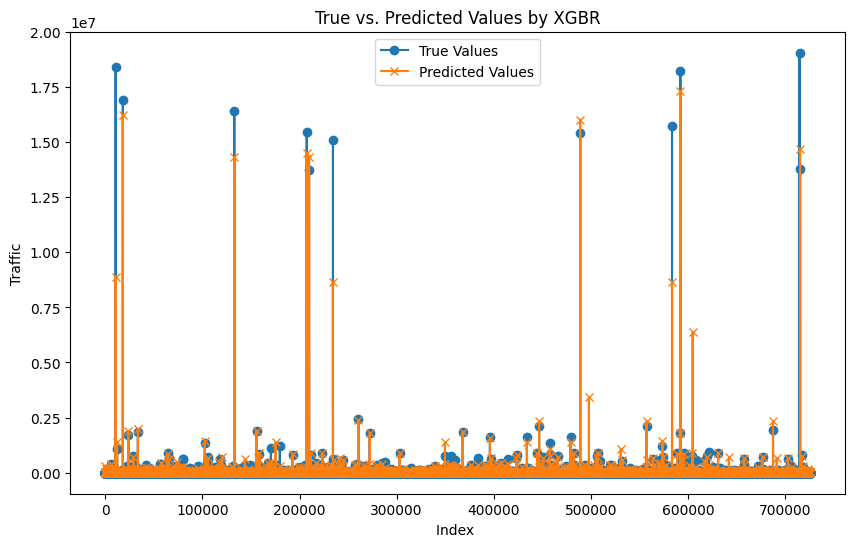

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(y_test, label='True Values', marker='o')
plt.plot(pred_xgboost, label='Predicted Values', marker='x')

plt.title('True vs. Predicted Values by XGBR')
plt.xlabel('Index ')
plt.ylabel('Traffic')
plt.legend()
plt.show()